In [16]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification, create_optimizer
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize
import re

from tqdm import tqdm

In [62]:
import psutil

def check_memory():
    try:
        mem = psutil.virtual_memory()
        print(f"Total memory: {mem.total / (1024 ** 3):.2f} GB")
        print(f"Available memory: {mem.available / (1024 ** 3):.2f} GB")
        print(f"Used memory: {mem.used / (1024 ** 3):.2f} GB")
        print(f"Memory percentage: {mem.percent}%")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

check_memory()


Total memory: 8.00 GB
Available memory: 1.47 GB
Used memory: 2.68 GB
Memory percentage: 81.6%


In [18]:
# Define and read the CSV file
file_path = '/Users/pablonieuwenhuys/EatzAI/training/restaurant_reviews.csv'
data = pd.read_csv(file_path, delimiter=';', quotechar='"', on_bad_lines = "skip")


In [39]:
# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pablonieuwenhuys/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
data['Sentences'] = data['Review'].apply(sent_tokenize)

In [40]:
# Preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

data['Review'] = data['Review'].apply(preprocess_text)

In [22]:
# Flatten the list of sentences and create a corresponding list of labels (optional)
sentence_data = []
sentence_review_indices = []

for idx, sentences in enumerate(data['Sentences']):
    for sentence in sentences:
        sentence_data.append(sentence)
        sentence_review_indices.append(idx)

In [41]:
# Ensure all entries in the 'Review' column are strings
data['Review'] = data['Review'].astype(str)
data['count'] = data['Review'].apply(lambda x: len(x.split()))

In [25]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [26]:
# Tokenize the sentences using DistilBERT tokenizer
sentence_encodings = tokenizer(sentence_data, truncation=True, padding=True)

In [27]:
# Prepare TensorFlow dataset for sentence classification
sentence_dataset = tf.data.Dataset.from_tensor_slices(dict(sentence_encodings))

In [29]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [48]:
data['encoded_text'] = data['Label'].astype('category').cat.codes

data_texts = data['Review'].to_list()

data_labels = data['encoded_text'].to_list()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_texts, data_labels, test_size=0.2, random_state=0)

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# Define the optimizer
num_train_steps = len(train_dataset) * 7  # Assuming 7 epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=5e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=500
)

# Compile the model
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

for batch in train_dataset.take(1):
    x, y = batch
    print("Inputs:", x)
    print("Labels:", y)

    model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
    
    # Train the model
history = model.fit(train_dataset.batch(16), epochs=7, validation_data=val_dataset.batch(64))

In [30]:
tf.config.run_functions_eagerly(True)

In [52]:
# Perform sentence classification using the DistilBERT model
sentence_predictions = model.predict(sentence_dataset.batch(64))

1/1 [==============================] - 0s 310ms/step


In [54]:
# Decode the predicted labels
predicted_labels = tf.argmax(sentence_predictions.logits, axis=1).numpy()

In [55]:
# Add predicted labels back to the original DataFrame
data['Sentence_Predictions'] = data['Sentences'].apply(lambda x: [])

for idx, sentences in enumerate(data['Sentences']):
    start_idx = sum(len(data['Sentences'].iloc[i]) for i in range(idx))
    end_idx = start_idx + len(sentences)
    predictions = predicted_labels[start_idx:end_idx]
    data.at[idx, 'Sentence_Predictions'] = list(predictions)

In [ ]:
history = model.fit(train_dataset.batch(16), epochs=5, validation_data=val_dataset.batch(16))

In [56]:
review_idx = 1  # Change this index to look at different reviews
print("Original Review:", data['Review'].iloc[review_idx])
print("Sentences:", data['Sentences'].iloc[review_idx])
print("Predicted Labels:", data['Sentence_Predictions'].iloc[review_idx])


Original Review: id recommend the fried catfish cheesy grits everything was good though
Sentences: ["I'd recommend the Fried Catfish Cheesy Grits, everything was good though."]
Predicted Labels: [2]


In [50]:
print(data[['Label', 'encoded_text']].drop_duplicates())

      Label  encoded_text
0      food             1
3   service             2
4  ambiance             0


In [61]:
# Display the first few rows of the DataFrame to see the sentence predictions
print(data[['Review', 'Sentences', 'Sentence_Predictions']].head(5))


                                              Review  \
0  excellent food  my highlights were definitely ...   
1  id recommend the fried catfish cheesy grits ev...   
2  excellent spot in the city if youre craving so...   
3           cool waiter with spot on recommendations   
4  the atmosphere was also great jazzy music and ...   

                                           Sentences Sentence_Predictions  
0  [Excellent food - my highlights were definitel...            [2, 2, 2]  
1  [I'd recommend the Fried Catfish Cheesy Grits,...                  [2]  
2  [Excellent spot in the City if you're craving ...                  [2]  
3        [Cool waiter with spot on recommendations.]                  [2]  
4  [The atmosphere was also great, jazzy music an...                  [2]  


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 800x800 with 0 Axes>

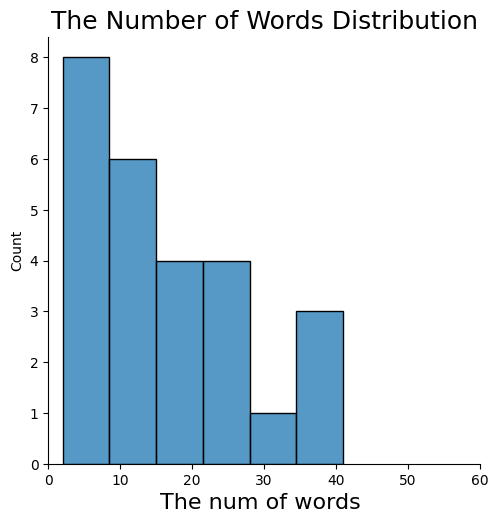

In [42]:
plt.figure(figsize= (8, 8))

sns.displot(data['count'])
#change 60 for the number of words axis to change
plt.xlim(0, 60)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [46]:
label_count = data['Label'].value_counts()

labels = label_count.index

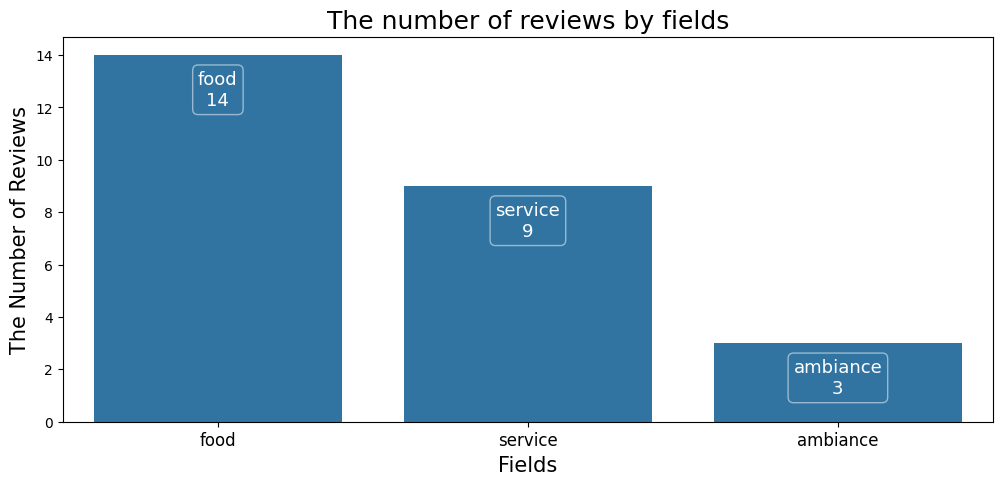

In [44]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = label_count.index, y = label_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{labels[a]}\n' + format(p.get_height(), '.0f'), 
                xy=(p.get_x() + p.get_width() / 2.0, p.get_height()), 
                xytext=(0, -25), 
                size=13, 
                color='white', 
                ha='center', 
                va='center', 
                textcoords='offset points', 
                bbox=dict(boxstyle='round', facecolor='none', edgecolor='white', alpha=0.5))

plt.xlabel('Fields', size=15)
plt.ylabel('The Number of Reviews', size=15)
plt.xticks(size=12)
plt.title("The number of reviews by fields", size=18)
plt.show()